# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

In [12]:
import pandas as pd
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import math

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.

In [13]:
columns = ['indexes', 'previous_event_index', 'time', 'Magnitude', 'latitude', 'longitude', 'depth']
filename = "SouthCalifornia-1982-2011.dat"
df = pd.read_csv(filename, index_col=0, header=None, names=columns, sep=' ')
df

,previous_event_index,time,Magnitude,latitude,longitude,depth
indexes,,,,,,
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546
...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121


In [14]:
# Get the timestamp, which is the seconds from January 1st 1982
tstamp = pd.Timestamp(dt.datetime(1982, 1, 1, 0, 0, 0, 1))

# converting the timestamps in seconds to their dates 
df['date'] = pd.to_datetime(df['time'], unit ='s', origin=tstamp)
df

,previous_event_index,time,Magnitude,latitude,longitude,depth,date
indexes,,,,,,,
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602,1982-01-01 00:00:00.000000000
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373,1982-01-01 10:08:21.390720000
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232,1982-01-01 10:24:48.277440000
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479,1982-01-01 13:19:42.516480000
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546,1982-01-01 16:44:28.570560000
...,...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743,2011-06-27 16:06:08.170560000
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285,2011-06-27 19:25:04.728000256
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121,2011-06-28 01:03:15.733440000


In [15]:
# We first sort the data w.r.t the time to ensure the ascendent order of the events in time
df = df.sort_values('time')
df

,previous_event_index,time,Magnitude,latitude,longitude,depth,date
indexes,,,,,,,
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602,1982-01-01 00:00:00.000000000
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373,1982-01-01 10:08:21.390720000
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232,1982-01-01 10:24:48.277440000
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479,1982-01-01 13:19:42.516480000
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546,1982-01-01 16:44:28.570560000
...,...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743,2011-06-27 16:06:08.170560000
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285,2011-06-27 19:25:04.728000256
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121,2011-06-28 01:03:15.733440000


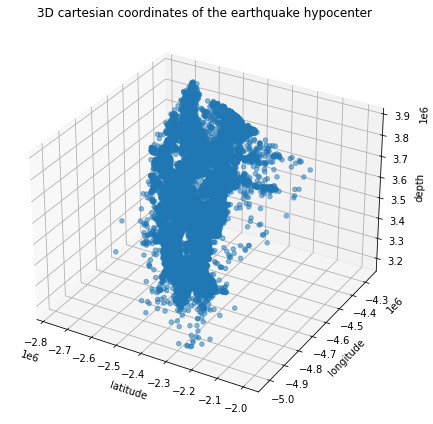

In [16]:
# 3D plot 
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['latitude'], df['longitude'], df['depth'], alpha=0.5)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_zlabel('depth')
ax.set_title('3D cartesian coordinates of the earthquake hypocenter')
plt.tight_layout()

we tried to convert the cartesian coordinates to spherical in order to improve the visualization of our 3D graph.

In [17]:
def cartesian_to_spherical(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)
    return r, theta, phi

df['r'], df['theta'], df['phi'] = cartesian_to_spherical(df['longitude'], df['latitude'], df['depth'])
df.head()

,previous_event_index,time,Magnitude,latitude,longitude,depth,date,r,theta,phi
indexes,,,,,,,,,,
0,-1,0.00000,2.71,-2571956,-4627162,3520602,1982-01-01 00:00:00.000000,6.357690e+06,0.983929,-2.634278
1,0,36501.39072,2.12,-2363740,-4787011,3461373,1982-01-01 10:08:21.390720,6.362692e+06,0.995587,-2.682932
2,0,37488.27744,2.33,-2363746,-4786942,3461232,1982-01-01 10:24:48.277440,6.362565e+06,0.995600,-2.682925
3,0,47982.51648,2.57,-2475085,-4664024,3548479,1982-01-01 13:19:42.516480,6.361672e+06,0.979075,-2.653707
4,0,60268.57056,2.98,-2238642,-4839098,3469546,1982-01-01 16:44:28.570560,6.361300e+06,0.993913,-2.708297


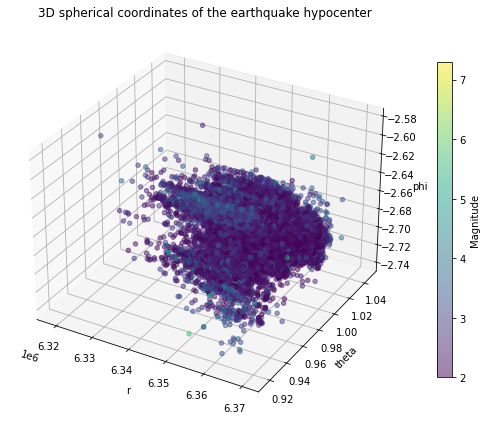

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
dcor = ax.scatter(df['r'], df['theta'], df['phi'], c=df['Magnitude'], alpha=0.5)
ax.set_xlabel('r')
ax.set_ylabel('theta')
ax.set_zlabel('phi')
ax.set_title('3D spherical coordinates of the earthquake hypocenter')
viz = plt.colorbar(dcor, ax=ax, shrink=0.8)
viz.set_label(label='Magnitude')
plt.tight_layout()

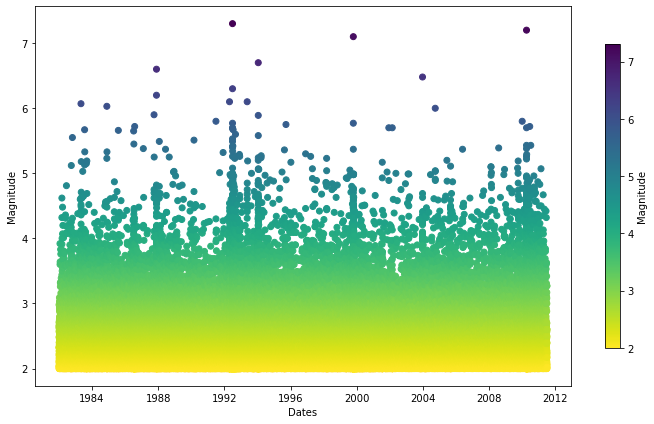

In [46]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
ax.set_xlabel('Dates')
ax.set_ylabel('Magnitude')
sp = ax.scatter(df['date'], df['Magnitude'], c=df['Magnitude'], cmap='viridis_r')
cb = plt.colorbar(sp, ax=ax, shrink=0.8)
cb.set_label(label='Magnitude')
plt.tight_layout()

In [19]:
# adding a new column to the df to define the hypocenters
df['hypocenter'] = np.sqrt(df['latitude']**2 + df['longitude']**2 + df['depth']**2)

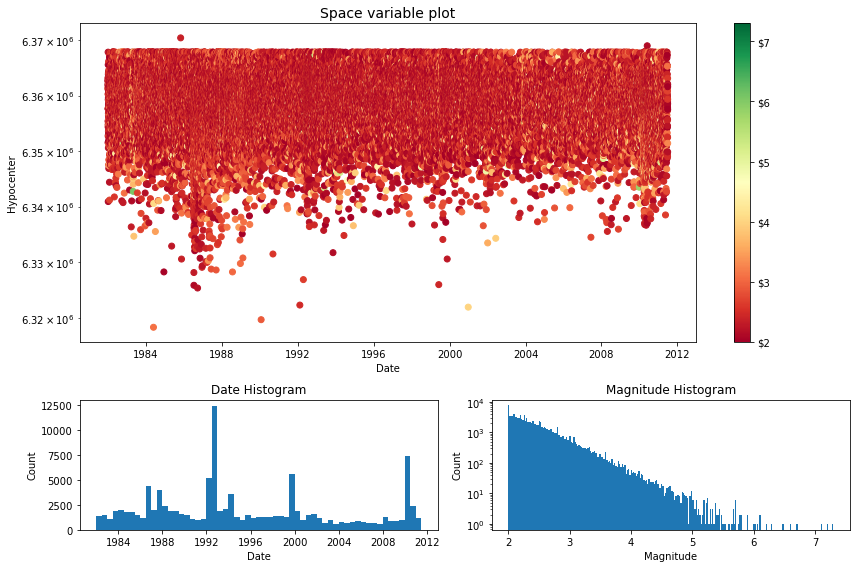

In [20]:
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
scatter = ax1.scatter(x=df['date'], y=df['hypocenter'], c=df['Magnitude'], cmap='RdYlGn') # create the scatter plot in ax1
plt.colorbar(scatter, ax=ax1, format='$%d') # create the color bar on the right (note that we need to specify the ax)
ax1.set_title('Space variable plot', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Hypocenter')
ax1.set_yscale('log') # use logarithmic y axis scale

# create the two 1D histograms of single variables
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax2.set_title('Date Histogram')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
n2, bins2, patches2 = ax2.hist(df['date'], bins='auto')


ax3 = plt.subplot2grid(gridsize, (2, 1))
ax3.set_title('Magnitude Histogram')
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Count')
n3, bins3, patches3 = ax3.hist(df['Magnitude'], bins='auto', log=True)

plt.tight_layout()

2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.

In [21]:
def Pm_t(df,m):
    '''Pm_t returns the distibution of the waiting time between each two events of magnitude m or above'''
    
    #we first select the events having magnitude m or avove
    df_m=df[df['Magnitude'] >= m]
    
    #wt consist of the waiting time between every two events
    wt=df_m['time'].diff()
    
    #We compute the histogram of waiting times
    log_bin = np.logspace(start=1,stop=np.log10(wt.max()),base=10, num=100)
    counts, bin_edges = np.histogram(wt, bins=log_bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    #We nomalize the counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)
    
    #We filter out the counts equal to 0
    counts_n_F = counts_n[counts_n != 0]
    bin_centers= bin_centers[counts_n != 0]
    
    return bin_centers,counts_n_F

Now we can visualize the distribution $P_m(t)$ in log-log scale.

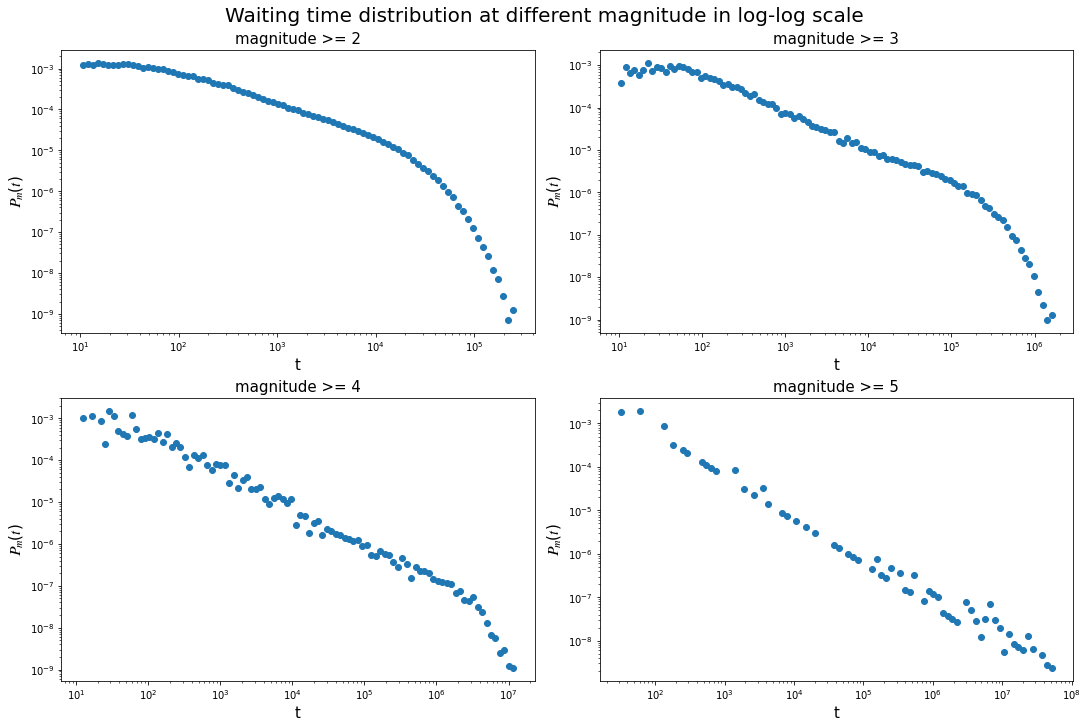

In [33]:
fig, ax = plt.subplots(2,2,figsize=(15, 10), constrained_layout=True)   
fig.suptitle("Waiting time distribution at different magnitude in log-log scale", fontsize=20)
m = 2
for i in range(2):
    for j in range(2):
        ax[i,j].plot(Pm_t(df,m)[0], Pm_t(df,m)[1],'o')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude >= %d'%m, fontsize=15)
        ax[i,j].set_xlabel('t', fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$', fontsize=15)
        m += 1

As the data is expected to follow a power-law decay with time, the log-log plot of the data should be a straight line with slope equal to the power-law exponent. For our case the higher the magnitude the more the log-log plot is following a straint line.

In other terms, the power-law decay describes a relationship between two variables where one decreases proportionally to the power of the other. It has the form:  $y = kx^{n}$ with $n<0$. And in the logarithmic scale:

$log(y)$ = $log(k)$ + $nlog(x)$

which is similar to a linear function: $ax + b$ with $a=n$ and $b=log(k)$. Hence, we can fit a linear function to our data.

In [25]:
def f(x,a,b):
    '''f is a linear function we will be using to fit the data'''
    return a*x+b

In [26]:
def fit_data(df,m,dist):
    '''fit_data fit the given data with the function f'''
    x,y=dist(df,m)
    x = np.log10(x)
    y = np.log10(y)
    params, cov = optimize.curve_fit(f, x, y)
    return params

Now, we will plot the fitting lines on the graph along with the data points. This allows us to see the extent to which the data follows a power-law relationship and how well the power-law equation fits the data. By overlaying the fitting line on the data, we can get a clearer understanding of the relationship between the variables and how well the power-law equation captures that relationship.

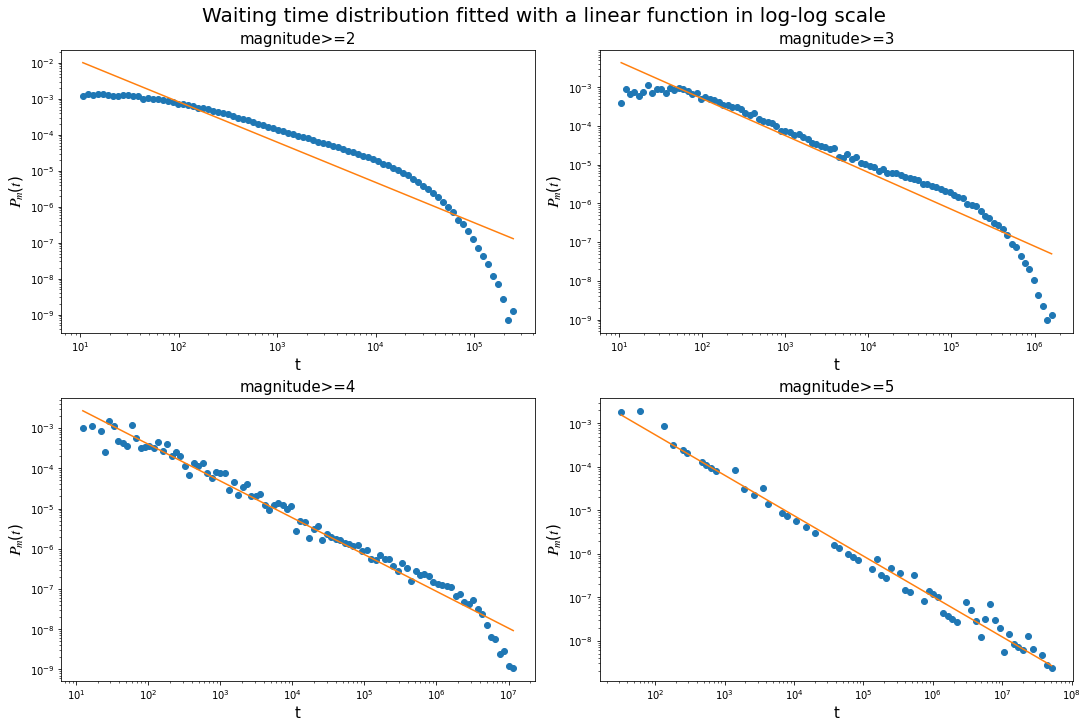

In [27]:
fig, ax = plt.subplots(2,2,figsize=(15, 10),constrained_layout=True)   
fig.suptitle("Waiting time distribution fitted with a linear function in log-log scale", fontsize=20)
m=2
for i in range(2):
    for j in range(2):
        a=fit_data(df,m,Pm_t)[0]
        b=fit_data(df,m,Pm_t)[1]
        x=Pm_t(df,m)[0]
        y=Pm_t(df,m)[1]
        ax[i,j].plot(x,y,'o')
        ax[i,j].plot(x, (10**b)*(x**a))
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude>=%d'%m,fontsize=15)
        ax[i,j].set_xlabel('t',fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$',fontsize=15)
        m+=1

We can see that the first two graphs for  $m >= 2$ and  $m >= 3$ don't respect the power-law relationship perfectly. But for  $m>=4$ and  $m>=5$ the power-law equation fits well the data.

3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.

We computed the same steps as in the previous question for the distribution of distances.

In [42]:
def Pm_r(df,m):
    '''Pm_r returns the distibution of the distance  between each two events of magnitude m or above'''
    
    #we first select the events having magnitude m or avove
    df_m=df[df['Magnitude']>=m]
    
    #We compute the distances between each two events
    x=df_m['longitude'].diff()
    y=df_m['latitude'].diff()
    z=df_m['depth'].diff()
    d=np.sqrt((x**2 + y**2 + z**2))

    log_bin = np.logspace(start=1,stop=np.log10(d.max()),base=10, num=50)
    counts, bin_edges = np.histogram(d, bins=log_bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    #We nomalize the counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)
    
    #We filter out the counts equal to 0
    counts_n_F = counts_n[counts_n!=0]
    bin_centers= bin_centers[counts_n!=0]
    
    return bin_centers,counts_n_F

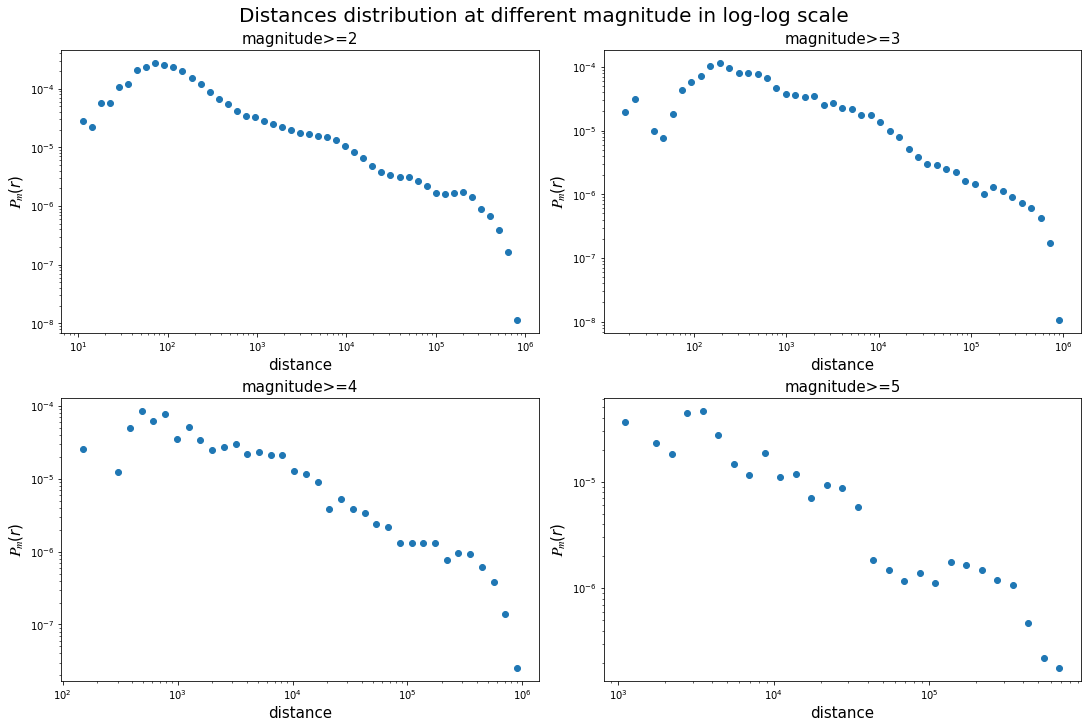

In [43]:
fig, ax = plt.subplots(2,2,figsize=(15, 10),constrained_layout=True)   
fig.suptitle("Distances distribution at different magnitude in log-log scale", fontsize=20)
m=2
for i in range(2):
    for j in range(2):
        ax[i,j].plot(Pm_r(df,m)[0], Pm_r(df,m)[1],'o')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude>=%d'%m,fontsize=15)
        ax[i,j].set_xlabel('distance',fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(r)$',fontsize=15)
        m+=1

The figures are similar to the ones we got while plotting the waiting time distribution. We can say that this distribution also has a power-law decay with distances.

We will try to fit the data with the same linear function f.

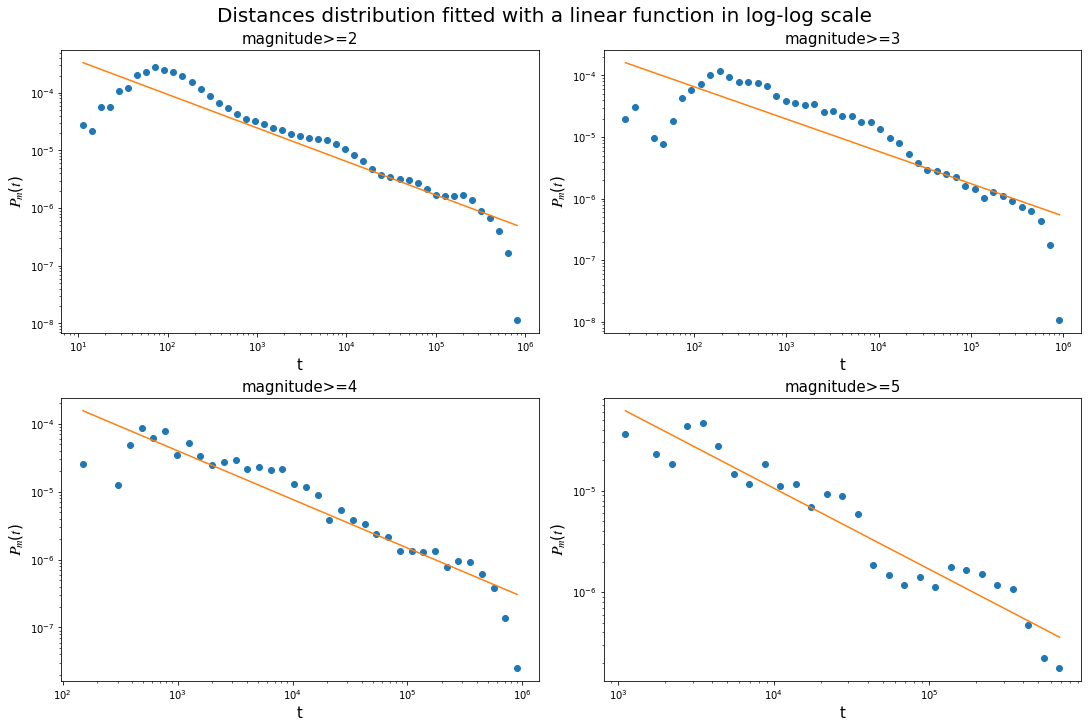

In [44]:
fig, ax = plt.subplots(2,2,figsize=(15, 10),constrained_layout=True)   
fig.suptitle("Distances distribution fitted with a linear function in log-log scale", fontsize=20)
m=2
for i in range(2):
    for j in range(2):
        a=fit_data(df,m,Pm_r)[0]
        b=fit_data(df,m,Pm_r)[1]
        x=Pm_r(df,m)[0]
        y=Pm_r(df,m)[1]
        ax[i,j].plot(x,y,'o')
        ax[i,j].plot(x, (10**b)*(x**a))
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude>=%d'%m,fontsize=15)
        ax[i,j].set_xlabel('t',fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$',fontsize=15)
        m+=1

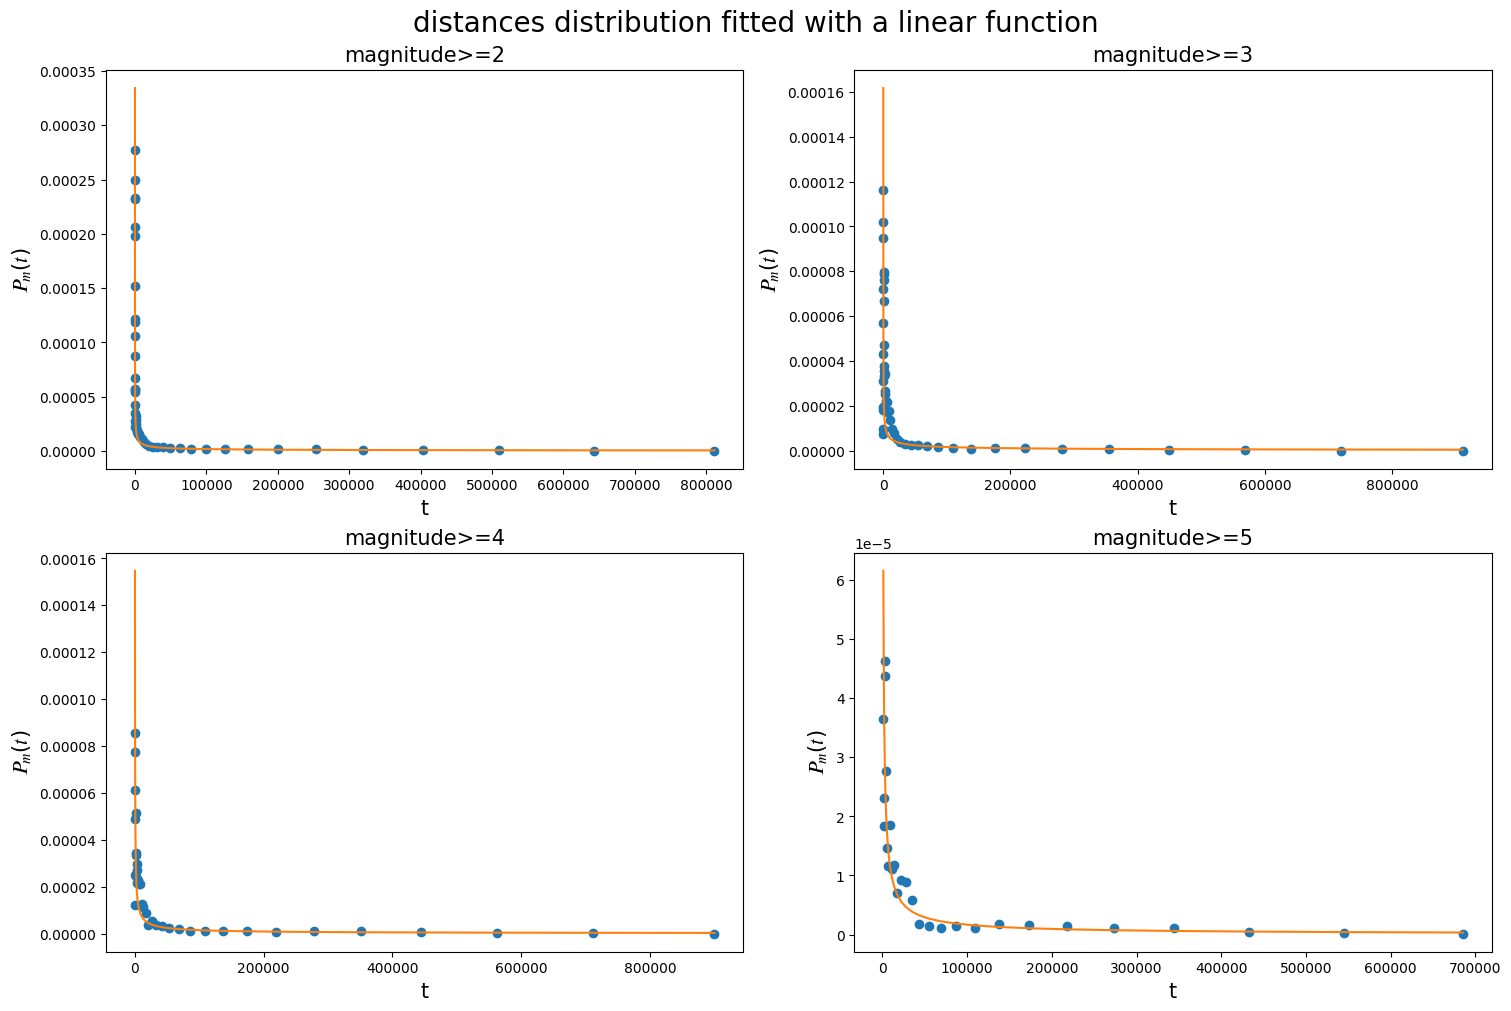

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15, 10),constrained_layout=True)   
fig.suptitle("distances distribution fitted with a linear function", fontsize=20)
m=2
for i in range(2):
    for j in range(2):
        a=fit_data(df,m,Pm_r)[0]
        b=fit_data(df,m,Pm_r)[1]
        x=Pm_r(df,m)[0]
        y=Pm_r(df,m)[1]
        ax[i,j].plot(x,y,'o')
        ax[i,j].plot(x, (10**b)*(x**a))
        ax[i,j].set_title('magnitude>=%d'%m,fontsize=15)
        ax[i,j].set_xlabel('t',fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$',fontsize=15)
        m+=1

In the distance distribution, the line is approxiamtively fitting the data.

4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.

In [45]:
def Pmr_t(df,m,R):
    
    df_1 = df.copy()
    
    #we select events that have a magnitude greater than or equal to m.
    df_m = df[df['Magnitude'] >= m]
    
    #we calculate the differences in longitude, latitude, and depth between consecutive events 
    df_1['x'] = df_m['longitude'].diff()
    df_1['y'] = df_m['latitude'].diff()
    df_1['z'] = df_m['depth'].diff()
    
    # we compute the Euclidean distance between consecutive events
    df_1['distance'] = np.sqrt((df_1['x']**2 + df_1['y']**2 + df_1['z']**2))
    
    #we filter out the events in df_1 where the distance is less than R 
    df_t = df_1[df_1['distance'] < R]
    
    #we calculate the time differences between consecutive events 
    serie = df_t['time'].diff()
    
    #we define a logarithmically spaced binning scheme using the logspace function, 
    #with bin edges ranging from 10 to the base-10 logarithm of the maximum value in serie,
    #creating 55 bins.
    logbin = np.logspace(start=math.log(10,10), stop=math.log(serie.max(),10), base=10, num=55)
    
    #we then compute a histogram of the time differences using  np.histogram
    counts, bin_edges = np.histogram(serie, bins=logbin)
    
    #we calculate the bin centers by taking the average of adjacent bin edges 
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    
    #we compute the bin widths by subtracting the adjacent bin edges 
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    #we calculate the normalization factor by summing up the counts 
    #then normalizes the counts by dividing them by the product of the bin widths and norm, 
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)
    
    #we filter out the counts and bin centers where the counts are not equal to zero
    counts_n_f = counts_n[counts_n!=0]
    bin_centers_f = bin_centers[counts_n!=0]
    
    #return the filtered centers and normalized counts
    return bin_centers_f,counts_n_f

We generate a 3 X 3 grid of subplots The code then enters a nested loop. The outer loop iterates over the rows of the grid (i ranging from 0 to 2), while the inner loop iterates over the columns of the grid (j ranging from 0 to 2).

The grid of subplots shows the waiting time distribution for different combinations of magnitude (m) and distance thresholds (R). The plots are displayed with logarithmic scales on both axes, allowing for a better visualization of the data.

After plotting the data in each subplot, the magnitude m is incremented by 1 to move to the next magnitude level within the outer loop. Then, the distance threshold R is multiplied by 100 to increase its value for the next column of subplots within the inner loop.






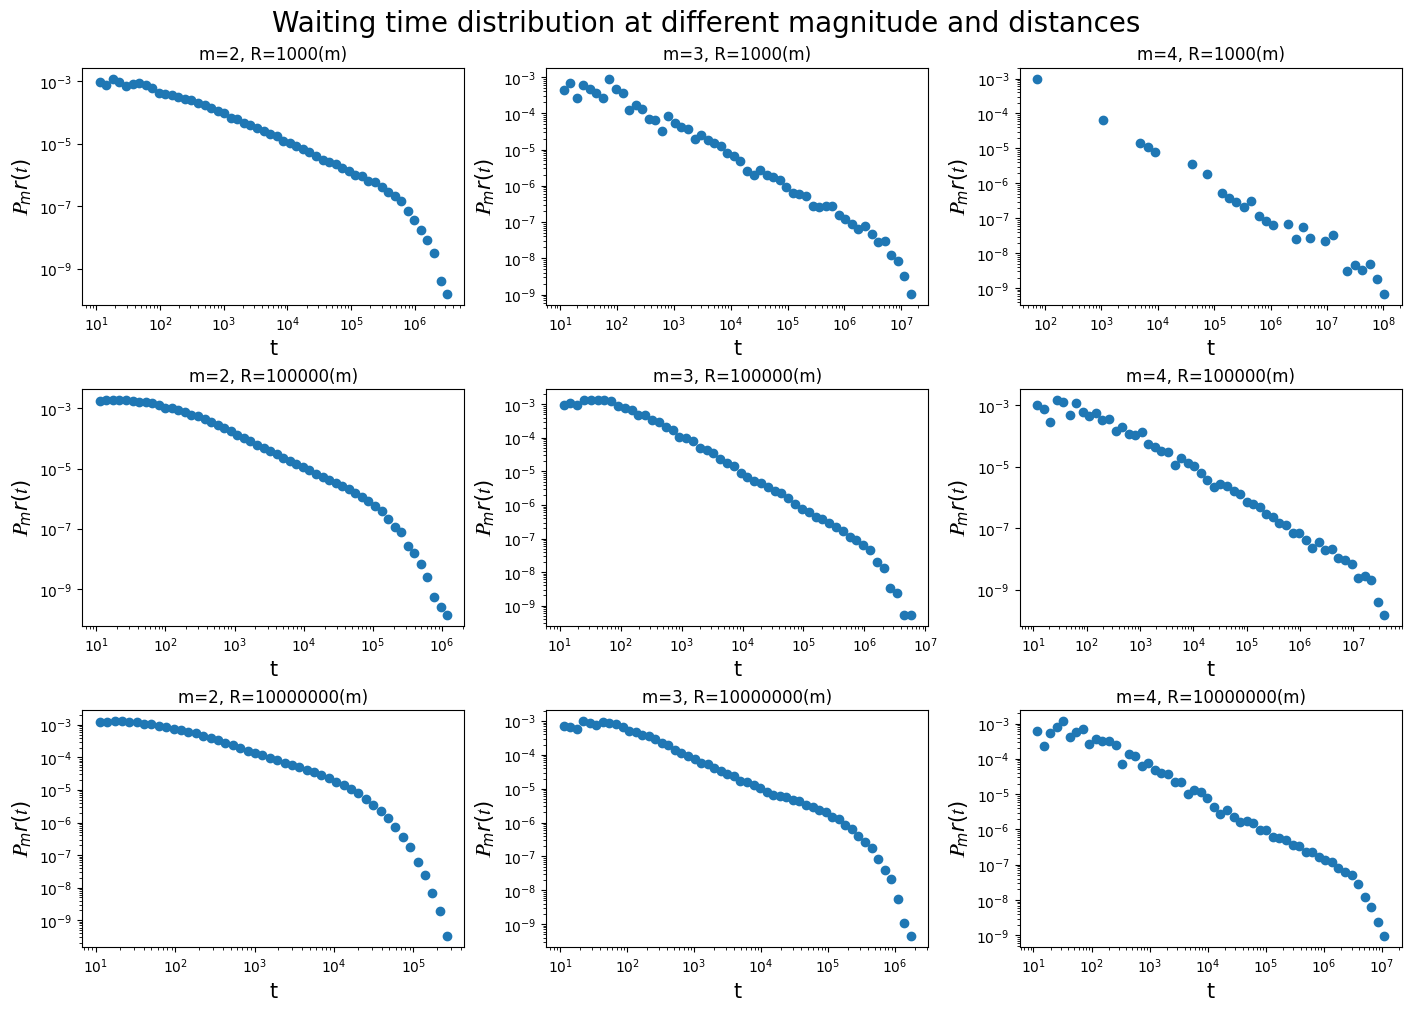

In [21]:
#Within each subplot, the code plots the waiting time distribution using the Pmr_t function 
#for a specific magnitude m and distance threshold R.
#It retrieves the bin centers and normalized counts from the Pmr_t function

fig, ax = plt.subplots(3,3,figsize=(14, 10),constrained_layout=True)   
fig.suptitle("Waiting time distribution at different magnitude and distances", fontsize=20)
R=1000
for i in range(3):
    m=2
    for j in range(3):
        #The x and y-axis scale of each subplot is set to a logarithmic scale
        #To ensure that both the x-axis and y-axis values are plotted on a logarithmic scale.
        ax[i,j].plot(Pmr_t(df,m,R)[0], Pmr_t(df,m,R)[1], 'o')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('m=%d, R=%d(m)'%(m,R))
        ax[i,j].set_xlabel('t',fontsize=15)
        ax[i,j].set_ylabel('$𝑃_mr(𝑡)$',fontsize=15)
        m+=1
    R*=100

5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?


A power law distribution is scale-free, meaning its shape remains the same when rescaled by a factor, except for a multiplicative constant. Rescaling is achieved by dividing the data by a characteristic size or unit of measurement. The center of bins in probability calculation helps accurately rescale the data. This allows the rescaled data to collapse onto a single curve, demonstrating the scale-free behavior of the power law distribution.

We rescale the waiting time distribution for different values of the magnitude using as characteristic length the average waiting time.

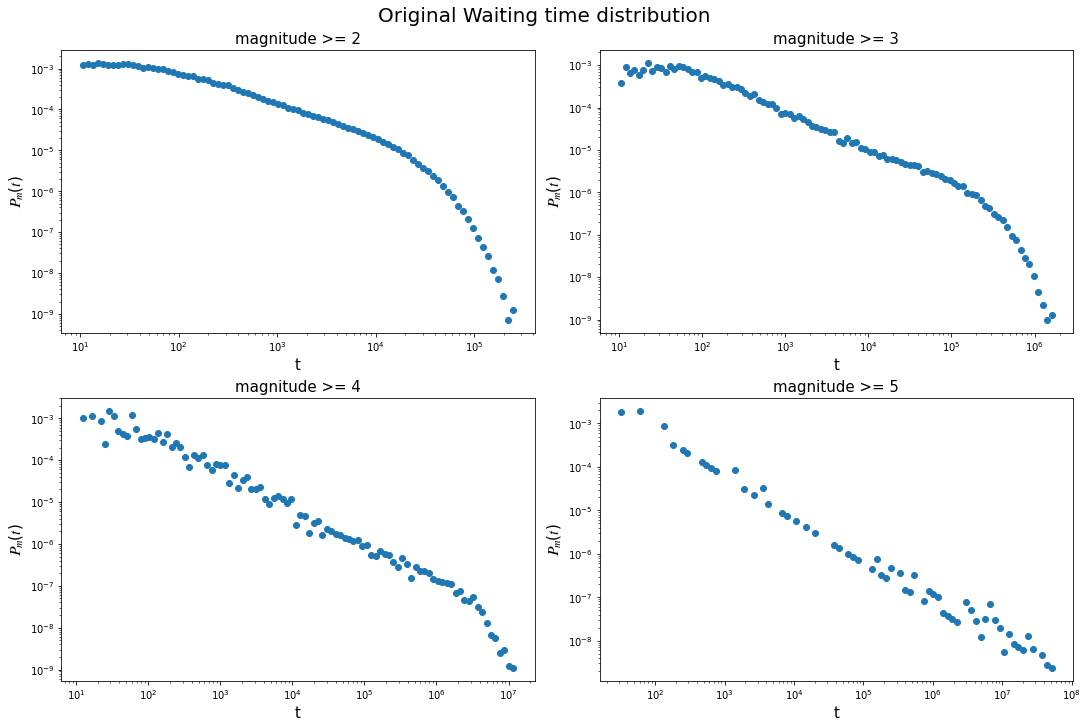

In [41]:
fig, ax = plt.subplots(2,2,figsize=(15, 10), constrained_layout=True)   
fig.suptitle("Original Waiting time distribution", fontsize=20)
m = 2
for i in range(2):
    for j in range(2):
        ax[i,j].plot(Pm_t(df,m)[0], Pm_t(df,m)[1],'o')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude >= %d'%m, fontsize=15)
        ax[i,j].set_xlabel('t', fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$', fontsize=15)
        m += 1



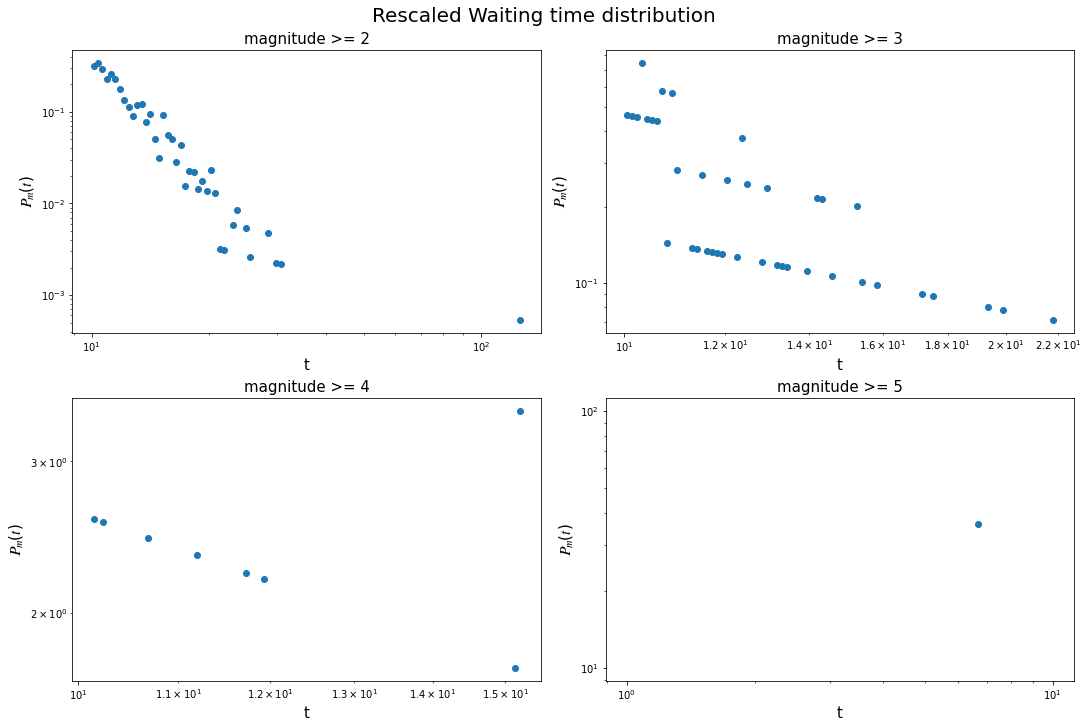

In [40]:
def Pm_t_res(df,m):
    '''Pm_t returns the rescaled distibution of the waiting time between each two events of magnitude m or above'''
    
    #we first select the events having magnitude m or avove
    df_m=df[df['Magnitude'] >= m]
    
    #wt consist of the waiting time between every two events
    wt=df_m['time'].diff()
    
    #we choose the mean of waiting time as the characteristic size or unit of measurement for rescaling
    wt_mean = np.mean(wt) 
    wt_res = df_m['time'].diff()/wt_mean
    
    # We compute the histogram of waiting times
    log_bin = np.logspace(start=1, stop=np.log10(wt_res.max()), base=10, num=100)
    log_bin = np.sort(log_bin)  # Sort the log_bin array in increasing order
    counts, bin_edges = np.histogram(wt_res, bins=log_bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    
    #nomalize the counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)
    
    #filter out the counts equal to 0
    counts_n_F = counts_n[counts_n != 0]
    bin_centers= bin_centers[counts_n != 0]
    
    return bin_centers,counts_n_F

fig, ax = plt.subplots(2,2,figsize=(15, 10), constrained_layout=True)   
fig.suptitle("Rescaled Waiting time distribution", fontsize=20)
m = 2
for i in range(2):
    for j in range(2):
        ax[i,j].plot(Pm_t_res(df,m)[0], Pm_t_res(df,m)[1],'o')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_title('magnitude >= %d'%m, fontsize=15)
        ax[i,j].set_xlabel('t', fontsize=15)
        ax[i,j].set_ylabel('$𝑃_𝑚(𝑡)$', fontsize=15)
        m += 1

It is observed that the data collapses on the curve after rescaling